# 🧬 Analyze scFoundation Embeddings

In this notebook, we load and explore the scFoundation bulk embeddings to understand their structure, distribution, and variation before applying dimensionality reduction (PCA).


In [2]:
import pandas as pd

# Load the embeddings + tissue annotations
embedding_df = pd.read_parquet("../../data/processed/bulk_with_pca_embeddings_tissue.parquet")

# Remove duplicates to ensure one row per cell line
embedding_unique = embedding_df.drop_duplicates(subset="SANGER_MODEL_ID").copy()


## 📥 Load and Inspect Embeddings

Let's load the `.npy` file containing scFoundation embeddings and look at its basic properties.


In [3]:
from sklearn.preprocessing import StandardScaler

# Get embedding features
embedding_cols = [col for col in embedding_unique.columns if col.startswith("SCF_PC")]

# Extract and scale the embeddings
X_emb = StandardScaler().fit_transform(embedding_unique[embedding_cols].values)


## 📊 Basic Embedding Statistics

Let's check the distribution of embedding norms and per-dimension statistics.


In [4]:
from sklearn.manifold import TSNE

tsne_emb = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne_emb.fit_transform(X_emb)

# Add t-SNE coordinates to DataFrame
embedding_unique["TSNE_1"] = tsne_coords[:, 0]
embedding_unique["TSNE_2"] = tsne_coords[:, 1]


In [5]:
# Convert one-hot tissue columns to single label
tissue_cols = [col for col in embedding_unique.columns if col.startswith("Tissue_")]
embedding_unique["Tissue"] = (
    embedding_unique[tissue_cols]
    .idxmax(axis=1)
    .str.replace("Tissue_", "")
    .str.replace("_", " ")
)


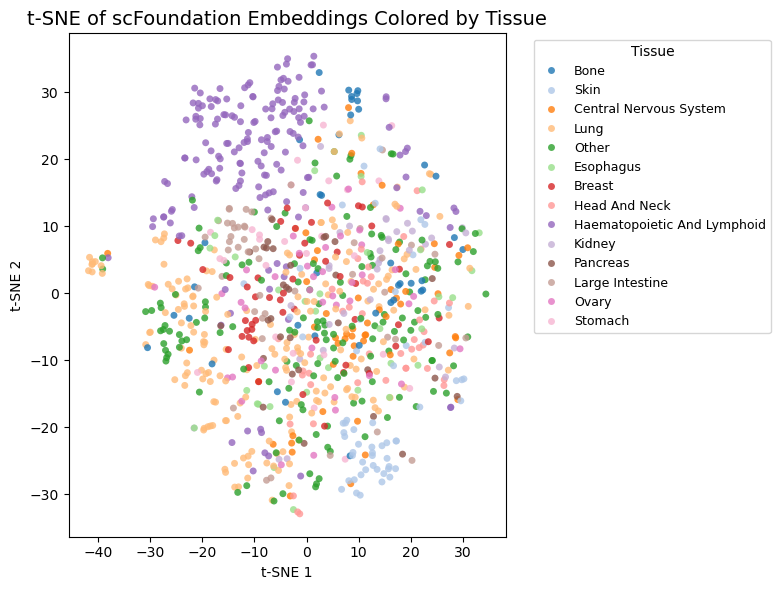

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=embedding_unique,
    x="TSNE_1",
    y="TSNE_2",
    hue="Tissue",
    palette="tab20",
    s=25,
    alpha=0.8,
    edgecolor="none"
)
plt.title("t-SNE of scFoundation Embeddings Colored by Tissue", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Tissue", fontsize=9)
plt.tight_layout()
plt.show()


## 🌀 Optional: Visualize Embeddings with t-SNE

We'll use t-SNE to visualize global structure in 2D.


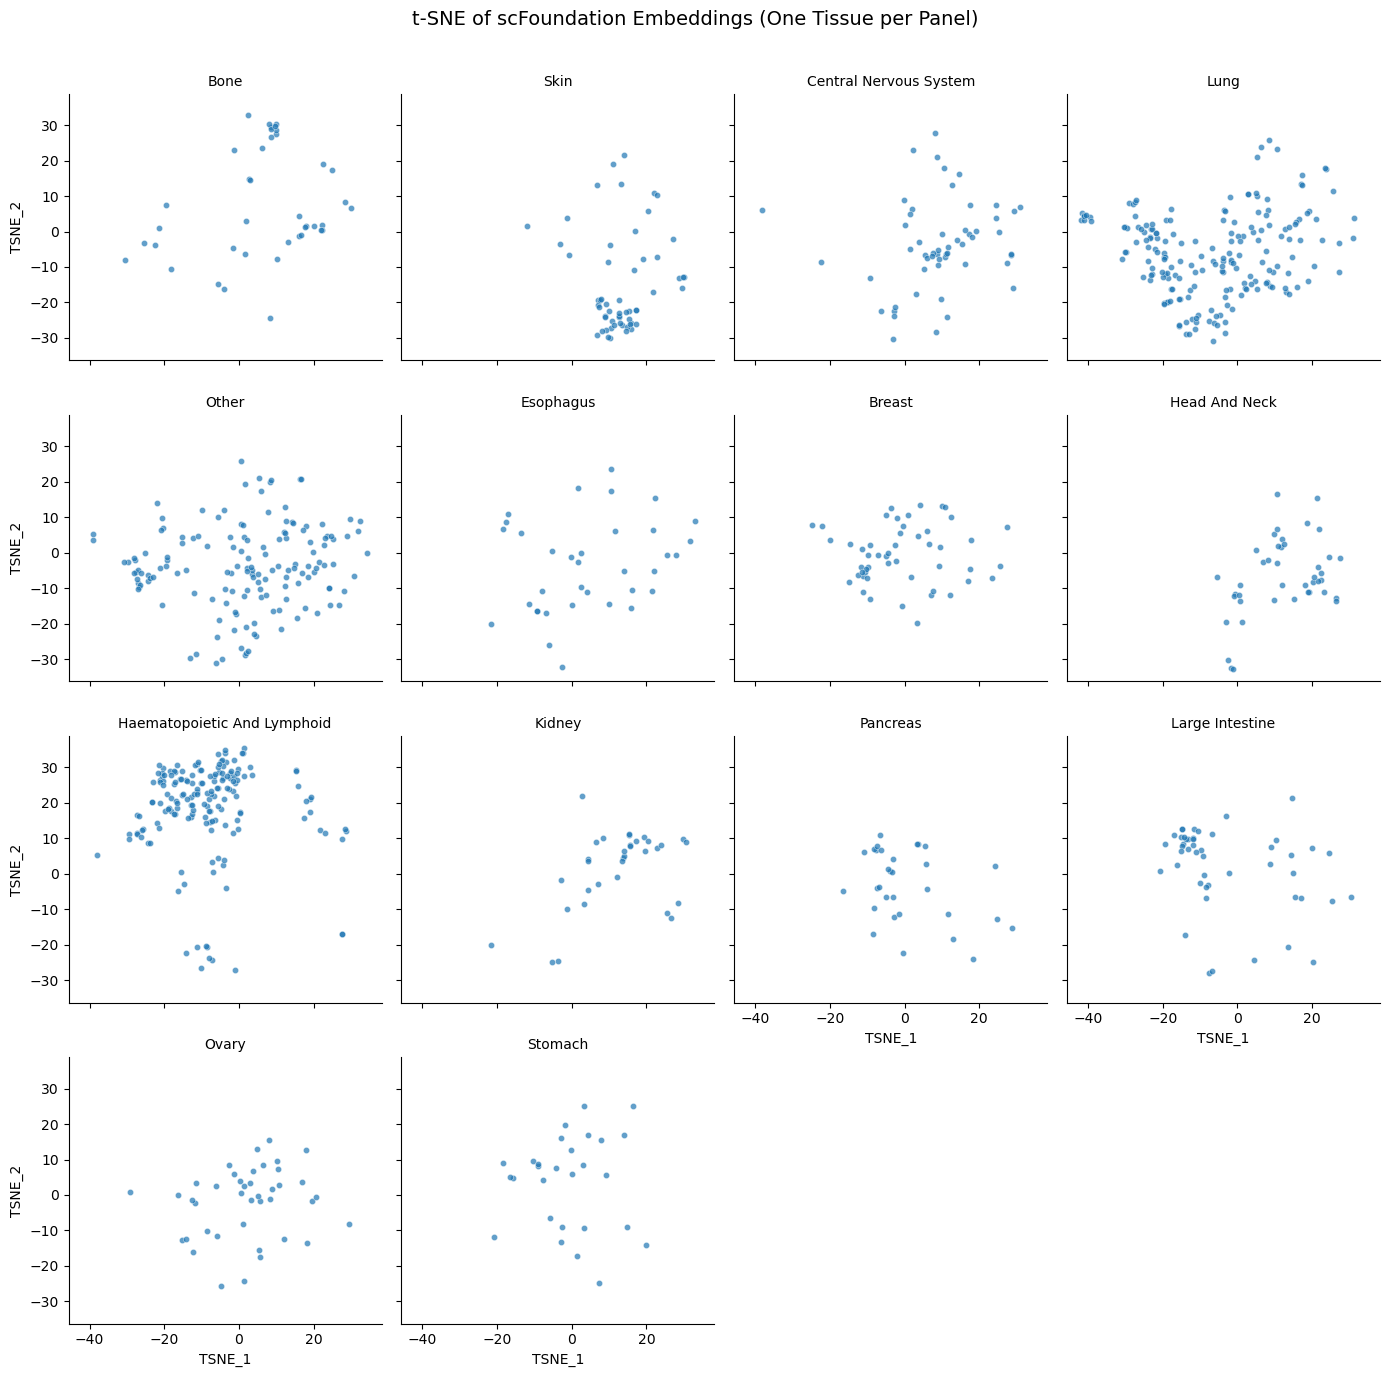

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(embedding_unique, col="Tissue", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="TSNE_1", y="TSNE_2", s=20, alpha=0.7)
g.set_titles(col_template="{col_name}", size=10)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("t-SNE of scFoundation Embeddings (One Tissue per Panel)", fontsize=14)
plt.show()


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


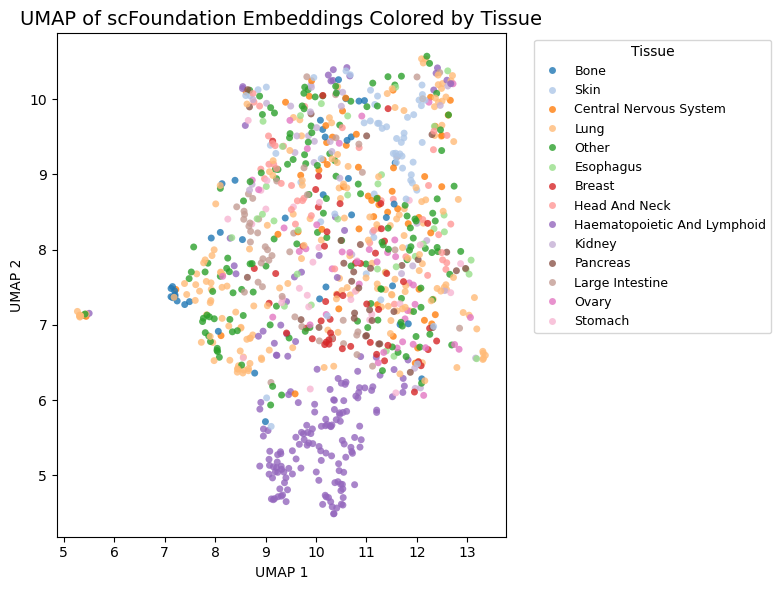

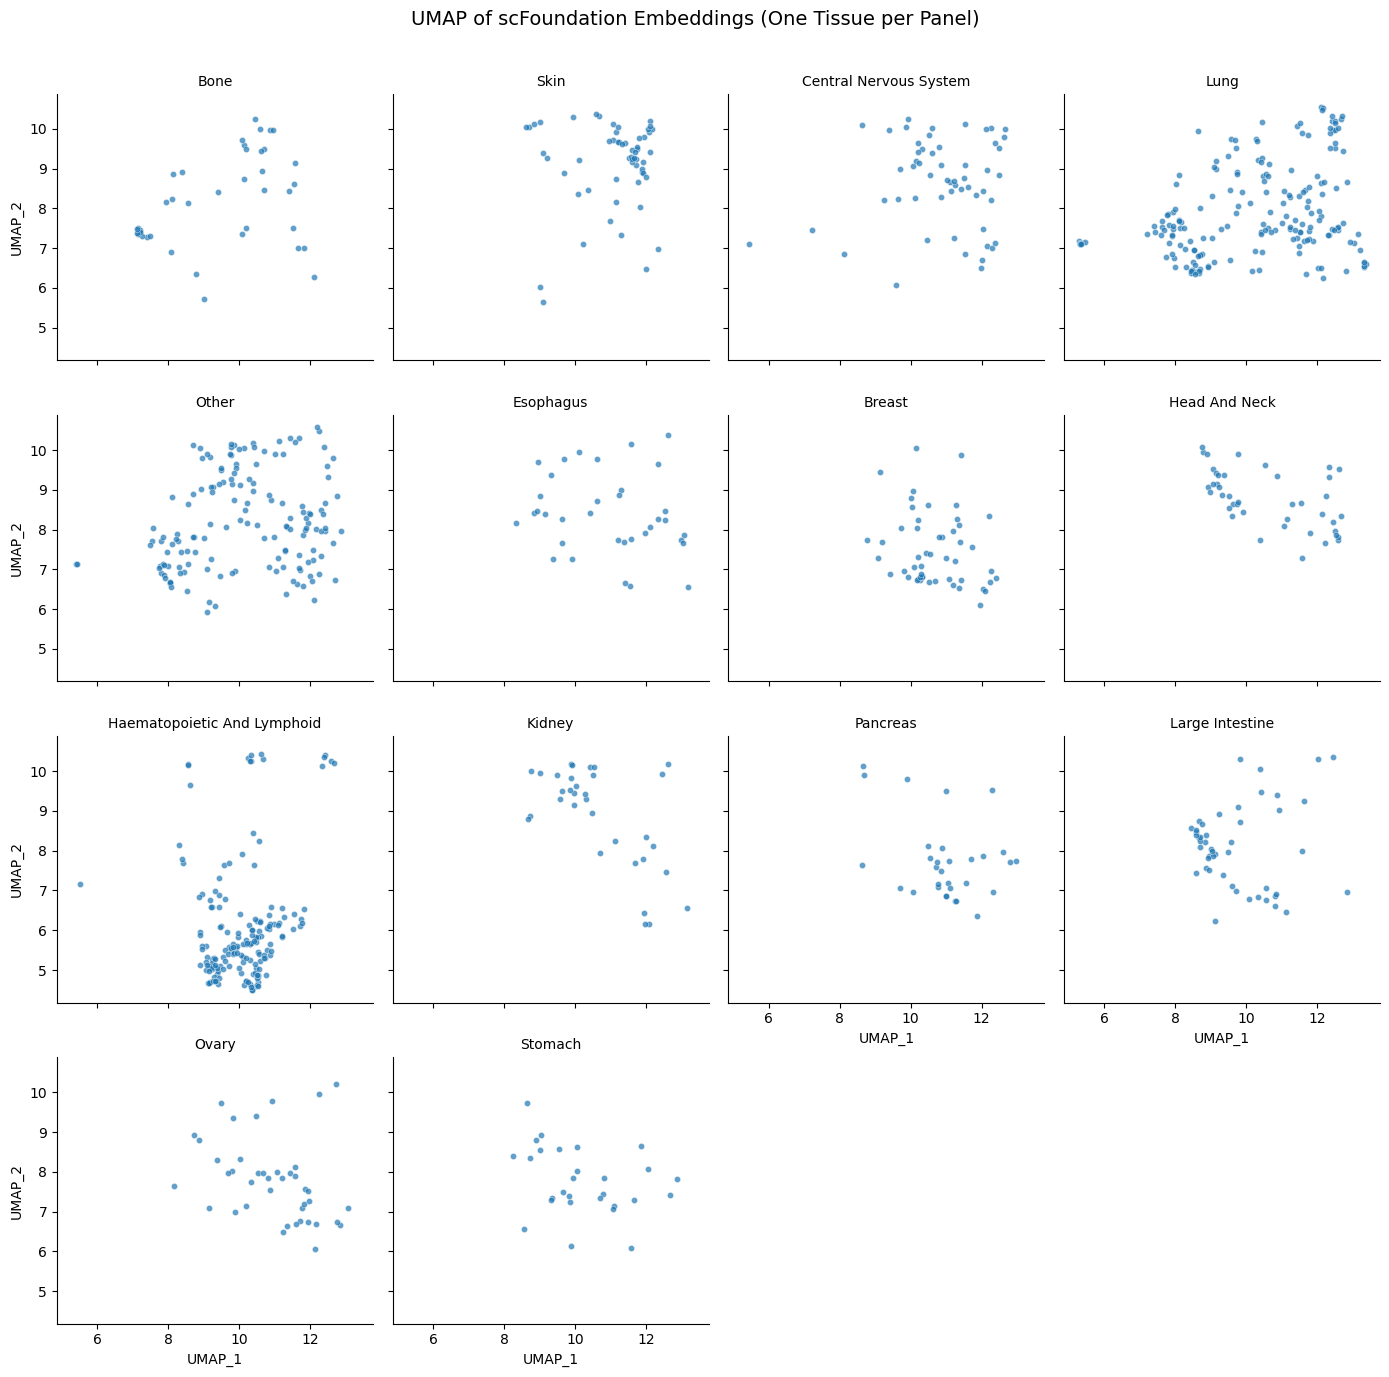

In [8]:
import umap

# Compute UMAP on scaled embeddings
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_coords = umap_reducer.fit_transform(X_emb)

# Add UMAP coordinates to DataFrame
embedding_unique["UMAP_1"] = umap_coords[:, 0]
embedding_unique["UMAP_2"] = umap_coords[:, 1]

# Plot UMAP colored by tissue
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=embedding_unique,
    x="UMAP_1",
    y="UMAP_2",
    hue="Tissue",
    palette="tab20",
    s=25,
    alpha=0.8,
    edgecolor="none"
)
plt.title("UMAP of scFoundation Embeddings Colored by Tissue", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Tissue", fontsize=9)
plt.tight_layout()
plt.show()

# Faceted UMAP per tissue for detailed inspection
g = sns.FacetGrid(embedding_unique, col="Tissue", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="UMAP_1", y="UMAP_2", s=20, alpha=0.7)
g.set_titles(col_template="{col_name}", size=10)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("UMAP of scFoundation Embeddings (One Tissue per Panel)", fontsize=14)
plt.show()


## ✅ Summary and Next Step

The embeddings appear to have consistent structure and variance. We'll now move on to applying PCA in the next notebook.


In [9]:
import numpy as np
import pandas as pd

# Load scFoundation embeddings
embedding_matrix = np.load("../../data/embeddings/bulk_embeddings_read_count.npy")

# Load corresponding metadata (cell line names)
meta_df = pd.read_csv("../../data/processed/bulk_filtered_for_scfoundation.csv", index_col=0)

# Check shapes match
print("Embeddings shape:", embedding_matrix.shape)
print("Metadata shape:", meta_df.shape)

# Assign cell line IDs
embedding_df = pd.DataFrame(embedding_matrix, index=meta_df.index)
embedding_df["SANGER_MODEL_ID"] = meta_df.index


Embeddings shape: (1362, 3072)
Metadata shape: (1362, 19265)


In [10]:
# Load one-hot encoded tissue data
tissue_dummies = pd.read_csv("../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv")

# Extract one-hot tissue column names
tissue_cols = [col for col in tissue_dummies.columns if col.startswith("Tissue_")]
tissue_names = [col.replace("Tissue_", "") for col in tissue_cols]

# Map from one-hot to actual tissue name
tissue_values = tissue_dummies[tissue_cols].values
tissue_idx = tissue_values.argmax(axis=1)
tissue_labels = pd.Series(tissue_idx).map(dict(enumerate(tissue_names)))

# Create tissue map DataFrame
tissue_map = tissue_dummies[["SANGER_MODEL_ID"]].copy()
tissue_map["Tissue"] = tissue_labels.values

# Ensure no duplicate SANGER_MODEL_ID
tissue_map = tissue_map.drop_duplicates(subset="SANGER_MODEL_ID")

# Prepare embedding_df index
if "SANGER_MODEL_ID" in embedding_df.index.names and "SANGER_MODEL_ID" not in embedding_df.columns:
    embedding_df = embedding_df.reset_index()

# Clean up duplicated column if exists
if "SANGER_MODEL_ID" in embedding_df.columns and embedding_df.index.name == "SANGER_MODEL_ID":
    embedding_df.index.name = None

# Merge tissue info
embedding_df = embedding_df.merge(tissue_map, on="SANGER_MODEL_ID", how="left")

# Load GDSC cleaned data
gdsc_df = pd.read_parquet("../../data/processed/gdsc_final_cleaned.parquet")

# Extract unique cell lines
gdsc_cell_lines = gdsc_df["SANGER_MODEL_ID"].unique()

# Filter the embedding_df to only include cell lines in GDSC
embedding_df_filtered = embedding_df[embedding_df["SANGER_MODEL_ID"].isin(gdsc_cell_lines)].copy()

# Confirm filtering
print(f"✅ Filtered embeddings to GDSC cell lines: {embedding_df_filtered.shape[0]} entries across {embedding_df_filtered['SANGER_MODEL_ID'].nunique()} cell lines.")

# Check for missing tissue values
print("✅ Missing tissue annotations:", embedding_df_filtered["Tissue"].isna().sum())


✅ Filtered embeddings to GDSC cell lines: 971 entries across 971 cell lines.
✅ Missing tissue annotations: 0


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Identify the embedding columns (assuming they start with a consistent prefix or are all float)
embedding_cols = embedding_df_filtered.select_dtypes(include=[float]).columns.tolist()

# Extract and normalize features
X_scaled = StandardScaler().fit_transform(embedding_df_filtered[embedding_cols].values)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# Add t-SNE coordinates to the DataFrame
embedding_df_filtered["TSNE_1"] = tsne_results[:, 0]
embedding_df_filtered["TSNE_2"] = tsne_results[:, 1]


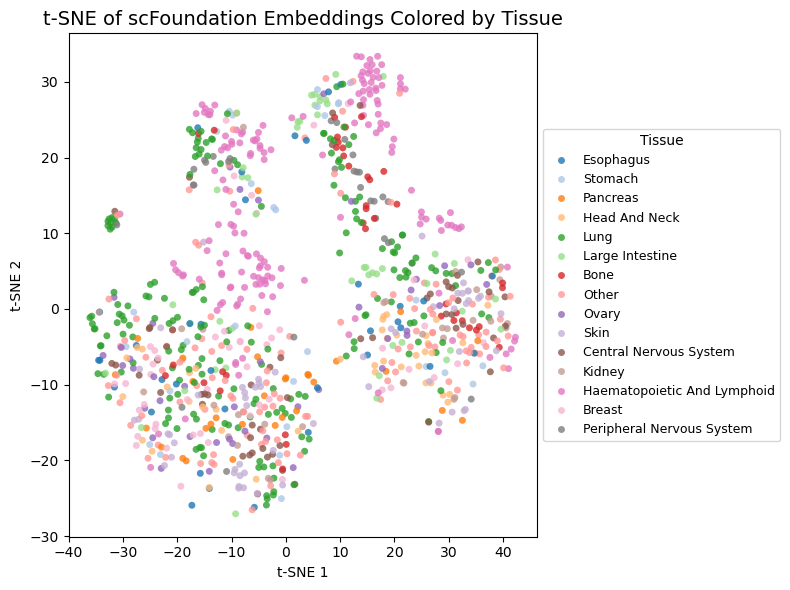

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=embedding_df_filtered,
    x="TSNE_1",
    y="TSNE_2",
    hue="Tissue",
    palette="tab20",
    s=25,
    alpha=0.8,
    edgecolor="none"
)
plt.title("t-SNE of scFoundation Embeddings Colored by Tissue", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Tissue", fontsize=9)
plt.tight_layout()
plt.show()


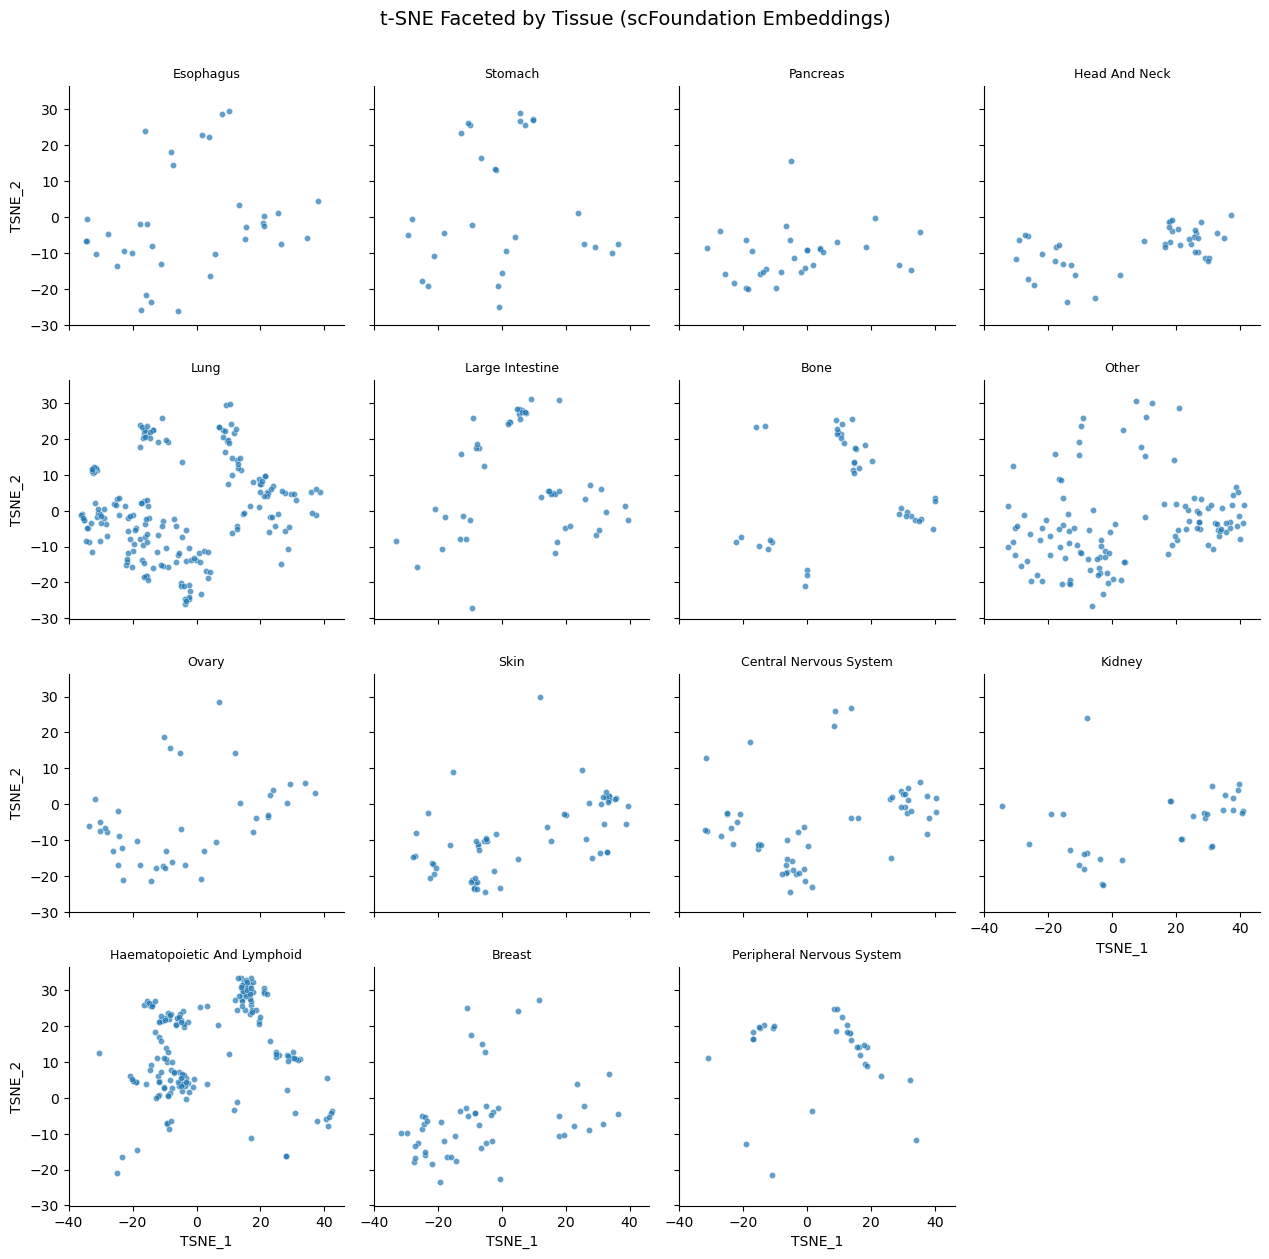

In [13]:
g = sns.FacetGrid(embedding_df_filtered, col="Tissue", col_wrap=4, height=3.2, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="TSNE_1", y="TSNE_2", s=20, alpha=0.7)
g.set_titles(col_template="{col_name}", size=9)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("t-SNE Faceted by Tissue (scFoundation Embeddings)", fontsize=14)
plt.show()


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


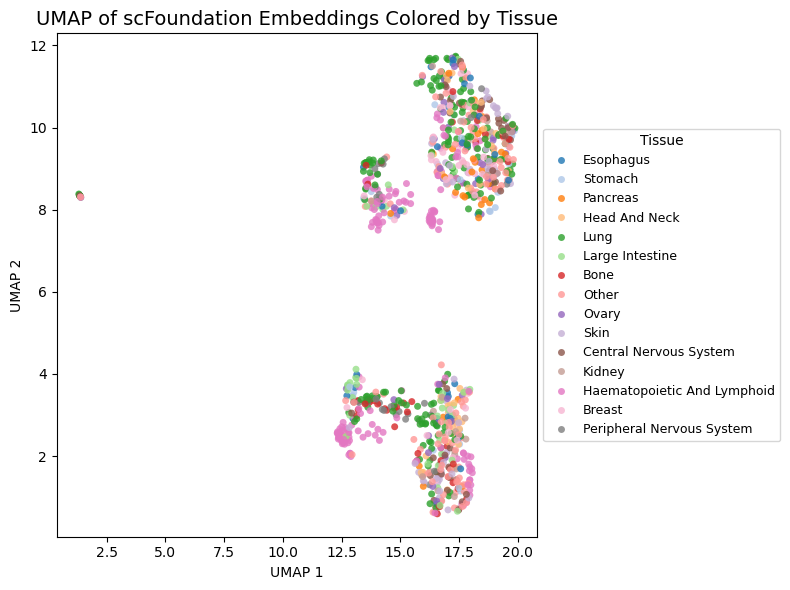

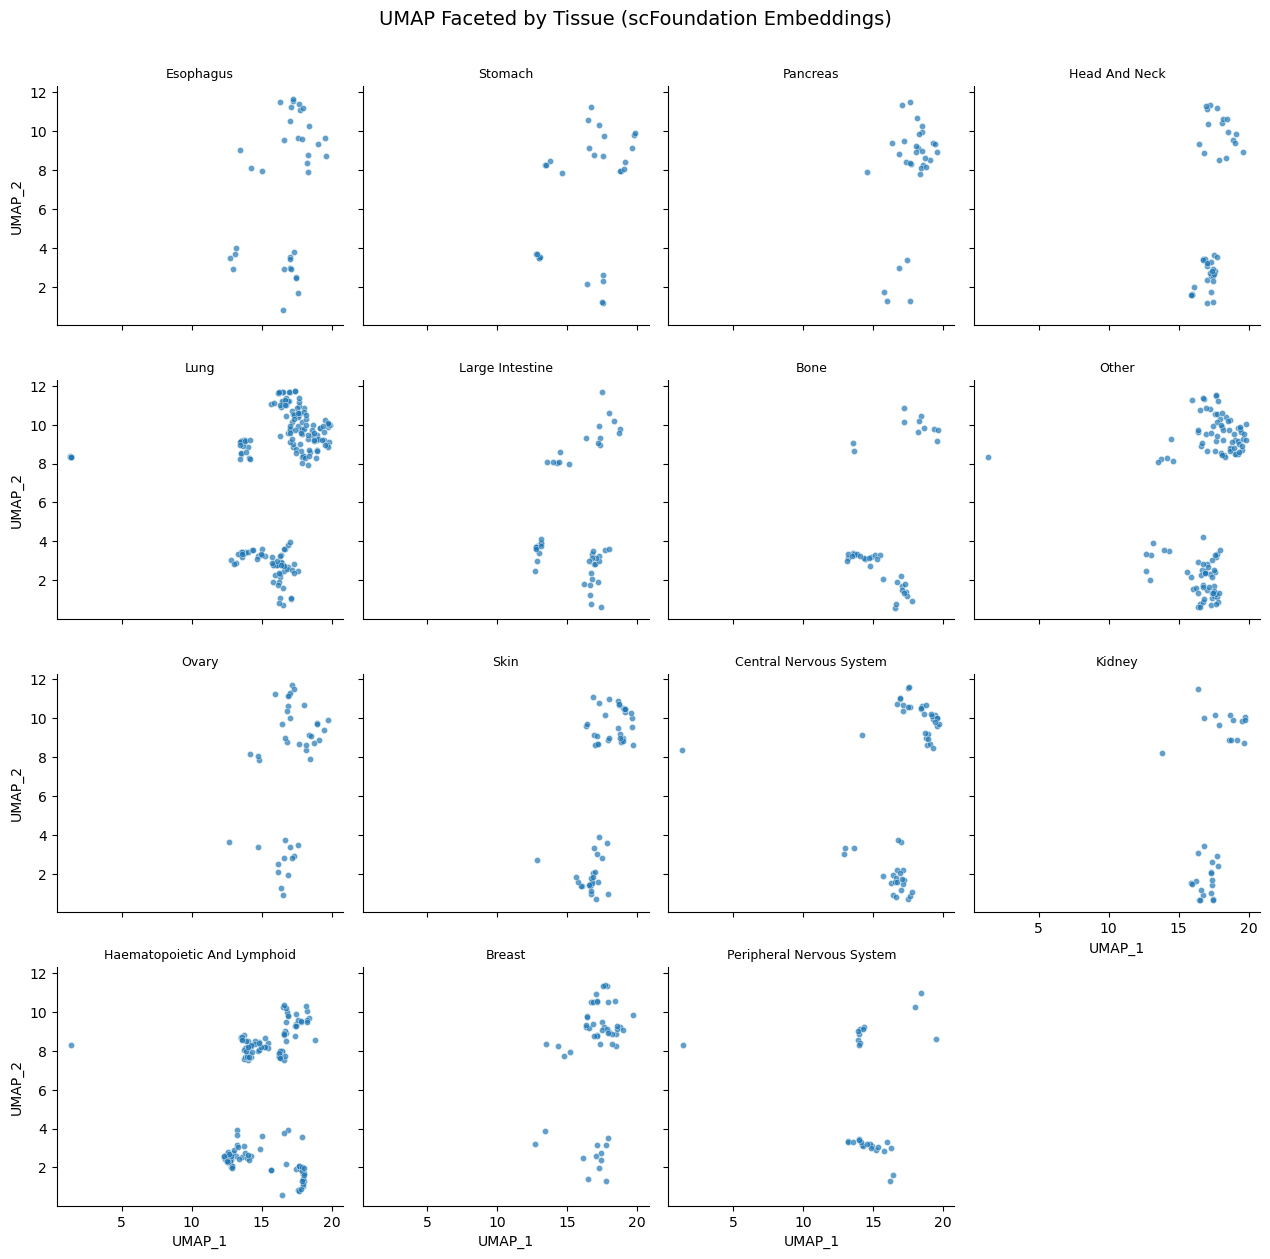

In [15]:
import umap

# Run UMAP on the scaled embeddings
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = umap_reducer.fit_transform(X_scaled)

# Add UMAP coordinates to the DataFrame
embedding_df_filtered["UMAP_1"] = umap_results[:, 0]
embedding_df_filtered["UMAP_2"] = umap_results[:, 1]

# Plot UMAP colored by tissue
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=embedding_df_filtered,
    x="UMAP_1",
    y="UMAP_2",
    hue="Tissue",
    palette="tab20",
    s=25,
    alpha=0.8,
    edgecolor="none"
)
plt.title("UMAP of scFoundation Embeddings Colored by Tissue", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Tissue", fontsize=9)
plt.tight_layout()
plt.show()

# Faceted UMAP per tissue for detailed inspection
g = sns.FacetGrid(embedding_df_filtered, col="Tissue", col_wrap=4, height=3.2, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="UMAP_1", y="UMAP_2", s=20, alpha=0.7)
g.set_titles(col_template="{col_name}", size=9)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("UMAP Faceted by Tissue (scFoundation Embeddings)", fontsize=14)
plt.show()


In [14]:
# Count per tissue
cell_lines_per_tissue = embedding_df_filtered.groupby("Tissue")["SANGER_MODEL_ID"].nunique().sort_values(ascending=False)

# Total count
total_cell_lines = embedding_df_filtered["SANGER_MODEL_ID"].nunique()

# Display
print("📊 Number of unique cell lines per tissue:")
print(cell_lines_per_tissue)
print(f"\n🔢 Total unique cell lines: {total_cell_lines}")


📊 Number of unique cell lines per tissue:
Tissue
Lung                           191
Haematopoietic And Lymphoid    170
Other                          118
Skin                            57
Central Nervous System          55
Breast                          51
Large Intestine                 48
Head And Neck                   42
Ovary                           41
Bone                            40
Esophagus                       35
Kidney                          33
Pancreas                        31
Peripheral Nervous System       31
Stomach                         28
Name: SANGER_MODEL_ID, dtype: int64

🔢 Total unique cell lines: 971
